<a href="https://colab.research.google.com/github/saniyaverma/Crop-Disease-Prediction-Models-analysis/blob/v1/Tomato_GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import json
from zipfile import ZipFile
import shutil
from PIL import Image
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

from tensorflow.keras import Model, callbacks, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML

In [2]:
# Load Kaggle credentials and download dataset
kaggle_credentials = json.load(open("kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

!kaggle datasets download -d kaustubhb999/tomatoleaf

# Unzip
with ZipFile("tomatoleaf.zip", 'r') as zip_ref:
    zip_ref.extractall()

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
 54% 96.0M/179M [00:00<00:00, 1.00GB/s]
100% 179M/179M [00:00<00:00, 722MB/s]  


In [3]:
# Paths from the dataset
train_path = "/content/tomato/train"
val_path = "/content/tomato/val"

**Create a unified folder**

In [4]:
# New unified folder
combined_path = "/content/tomato-leaf-disease"
os.makedirs(combined_path, exist_ok=True)

def combine_folders(source_dir, target_dir):
    for cls in os.listdir(source_dir):
        src_cls_path = os.path.join(source_dir, cls)
        dst_cls_path = os.path.join(target_dir, cls)
        os.makedirs(dst_cls_path, exist_ok=True)

        for file_name in os.listdir(src_cls_path):
            src_file = os.path.join(src_cls_path, file_name)
            dst_file = os.path.join(dst_cls_path, file_name)

            # Only copy if file doesn't already exist
            if not os.path.exists(dst_file):
                shutil.copy2(src_file, dst_file)

        print(f"Copied: {cls} from {source_dir} to {target_dir}")

# Combine all splits into one
combine_folders(train_path, combined_path)
combine_folders(val_path, combined_path)

Copied: Tomato___Spider_mites Two-spotted_spider_mite from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Target_Spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Tomato_mosaic_virus from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Late_blight from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___healthy from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Leaf_Mold from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Early_blight from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Tomato_Yellow_Leaf_Curl_Virus from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Bacterial_spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Septoria_leaf_spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Spider_mites Two-spotted_spider_mite from /cont

**Check for total image count**

In [5]:
def count_images_in_folders(folder_path):
    total_images = 0
    print(f"\nChecking folder: {folder_path}")
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            total_images += count
            print(f"{cls}: {count} images")
    print(f"\nTotal images: {total_images}")

# Run this:
count_images_in_folders("/content/tomato-leaf-disease")


Checking folder: /content/tomato-leaf-disease
Tomato___Bacterial_spot: 1100 images
Tomato___Early_blight: 1100 images
Tomato___Late_blight: 1100 images
Tomato___Leaf_Mold: 1100 images
Tomato___Septoria_leaf_spot: 1100 images
Tomato___Spider_mites Two-spotted_spider_mite: 1100 images
Tomato___Target_Spot: 1100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1100 images
Tomato___Tomato_mosaic_virus: 1100 images
Tomato___healthy: 1100 images

Total images: 11000


**Check for Corrupt or Unreadable Images**

In [6]:
def check_image_integrity(folder_path):
    broken = []
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        for img_file in os.listdir(cls_path):
            try:
                img_path = os.path.join(cls_path, img_file)
                with Image.open(img_path) as img:
                    img.verify()
            except Exception as e:
                broken.append(img_path)
                print(f"Corrupt: {img_path} — {e}")
    if not broken:
        print("All images verified successfully.")
    else:
        print(f"Found {len(broken)} corrupt images.")

check_image_integrity("/content/tomato-leaf-disease")


All images verified successfully.


In [7]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 30

**Import data into tensorflow dataset object**

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato-leaf-disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 11000 files belonging to 10 classes.


In [10]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

**Visualize some of the images from our dataset**

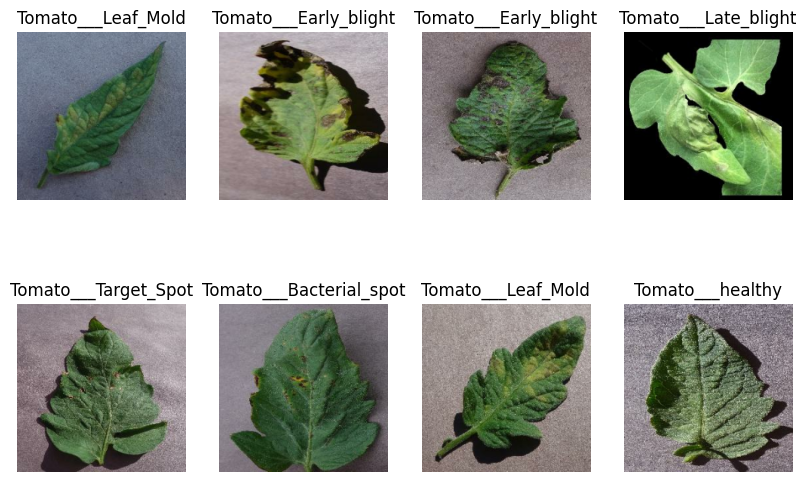

In [11]:
plt.figure(figsize=(10, 10))

# Take one batch (usually of 32 images) from the dataset
for image_batch, labels_batch in dataset.take(1):

    # Loop through the first 12 images in the batch
    for i in range(BATCH_SIZE):

        # Create a subplot in a 3x4 grid (3 rows, 4 columns)
        ax = plt.subplot(3, 4, i + 1)

        # Convert the 12 images in the batch to a NumPy array and display it
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # .astype("uint8") ensures correct color format

        # Convert the label tensor to a NumPy integer, use it to get the class name, and set as title
        plt.title(class_names[labels_batch[i]])

        # Turn off the axis ticks and grid for cleaner display
        plt.axis("off")

**Splitting the dataset**

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=123)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

1100

In [14]:
len(val_ds)

137

In [15]:
len(test_ds)

138

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

**Preprocessing the Data**

**Resizing & Rescaling**

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

**Data Augmentation**

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [19]:
# Train: resize → augment → prefetch
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), (y, y, y)), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [20]:
# Val/test: resize → prefetch (no augmentation)
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), (y, y, y)), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

**Loading the model**

In [21]:
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
    Flatten, Dropout, Dense, Input, BatchNormalization, Concatenate
)
from tensorflow.keras.models import Model

NUM_CLASSES = 10

def inceptionnet(x, filters, name=None):
    # 1x1 conv
    path1 = Conv2D(filters[0], (1,1), padding='same', activation='relu')(x)

    # 1x1 conv + 3x3 conv
    path2 = Conv2D(filters[1][0], (1,1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters[1][1], (3,3), padding='same', activation='relu')(path2)

    # 1x1 conv + 5x5 conv
    path3 = Conv2D(filters[2][0], (1,1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters[2][1], (5,5), padding='same', activation='relu')(path3)

    # 3x3 maxpool + 1x1 conv
    path4 = MaxPooling2D((3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters[3], (1,1), padding='same', activation='relu')(path4)

    return Concatenate(axis=-1, name=name)([path1, path2, path3, path4])

def helperfunction(x, name=None):
    x = AveragePooling2D((5,5), strides=3)(x)
    x = Conv2D(128, (1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(NUM_CLASSES, activation='softmax', name=name)(x)
    return x

def googlenet(input_shape=(224,224,3)):
    inputs = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    # Inception blocks + auxiliary classifiers
    x = inceptionnet(x, [64, (96,128), (16,32), 32], name='inception_3a')
    x = inceptionnet(x, [128, (128,192), (32,96), 64], name='inception_3b')
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inceptionnet(x, [192, (96,208), (16,48), 64], name='inception_4a')
    aux1 = helperfunction(x, name='aux_output_1')

    x = inceptionnet(x, [160, (112,224), (24,64), 64], name='inception_4b')
    x = inceptionnet(x, [128, (128,256), (24,64), 64], name='inception_4c')
    x = inceptionnet(x, [112, (144,288), (32,64), 64], name='inception_4d')
    aux2 = helperfunction(x, name='aux_output_2')

    x = inceptionnet(x, [256, (160,320), (32,128), 128], name='inception_4e')
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    x = inceptionnet(x, [256, (160,320), (32,128), 128], name='inception_5a')
    x = inceptionnet(x, [384, (192,384), (48,128), 128], name='inception_5b')

    # GlobalAveragePooling + final dense layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    final = Dense(NUM_CLASSES, activation='softmax', name='main_output')(x)

    # Build model
    model = Model(inputs=inputs, outputs=[final, aux1, aux2], name='GoogLeNet')
    return model

In [22]:
model = googlenet()
model.summary()

Model: "GoogLeNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a        │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 7,172,430 (27.36 MB)

 Trainable params: 7,171,918 (27.36 MB)

 Non-trainable params: 512 (2.00 KB)

In [23]:
learning_rate = 0.001
opti = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    loss_weights=[1, 0.3, 0.3],
    optimizer=opti,
    metrics=[['accuracy'], ['accuracy'], ['accuracy']]
)

In [24]:
# Callbacks
from tensorflow.keras import callbacks


early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_ckpt = callbacks.ModelCheckpoint(
    filepath="best_googlenet.h5",  # or best_alexnet.keras if using latest version
    save_best_only=True,
    monitor="val_loss"
)

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 151s 81ms/step - aux_output_1_accuracy: 0.2619 - aux_output_1_loss: 2.0556 - aux_output_2_accuracy: 0.2003 - aux_output_2_loss: 2.1180 - loss: 3.4072 - main_output_accuracy: 0.1780 - main_output_loss: 2.1551 - val_aux_output_1_accuracy: 0.2153 - val_aux_output_1_loss: 3.8701 - val_aux_output_2_accuracy: 0.2181 - val_aux_output_2_loss: 2.7004 - val_loss: 4.4761 - val_main_output_accuracy: 0.2473 - val_main_output_loss: 2.5049 - learning_rate: 0.0010
Epoch 2/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 93s 74ms/step - aux_output_1_accuracy: 0.6420 - aux_output_1_loss: 0.9898 - aux_output_2_accuracy: 0.5725 - aux_output_2_loss: 1.2017 - loss: 1.9013 - main_output_accuracy: 0.5392 - main_output_loss: 1.2438 - val_aux_output_1_accuracy: 0.8148 - val_aux_output_1_loss: 0.4874 - val_aux_output_2_accuracy: 0.7500 - val_aux_output_2_loss: 0.6727 - val_loss: 1.0528 - val_main_output_accuracy: 0.7381 - val_main_output_loss: 0.7047 - learning_rate: 0.0010
Epoch 3/20


In [26]:
acc = history.history['main_output_accuracy']
val_acc = history.history['val_main_output_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


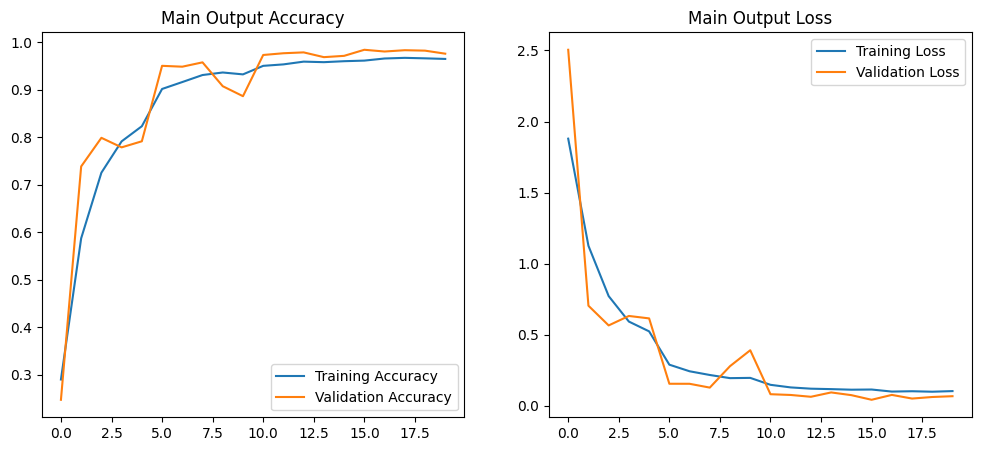

In [27]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(history.history['main_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_main_output_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Main Output Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['main_output_loss'], label='Training Loss')
plt.plot(history.history['val_main_output_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Main Output Loss')

plt.show()


first image to print


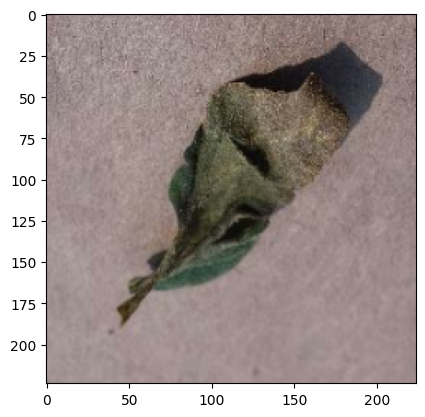

first image actual label: Tomato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
predicted label: Tomato___Late_blight


In [28]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to print")
    plt.imshow(first_image)
    plt.show()

    print("first image actual label:", class_names[first_label])

    # predict on batch: returns list [main_output, aux_output_1, aux_output_2]
    batch_prediction = model.predict(image_batch)

    # get main output predictions
    main_predictions = batch_prediction[0]

    # get the prediction vector for the first image
    first_pred = main_predictions[0]

    # get predicted class index
    predicted_class_idx = np.argmax(first_pred)

    print("predicted label:", class_names[predicted_class_idx])


In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


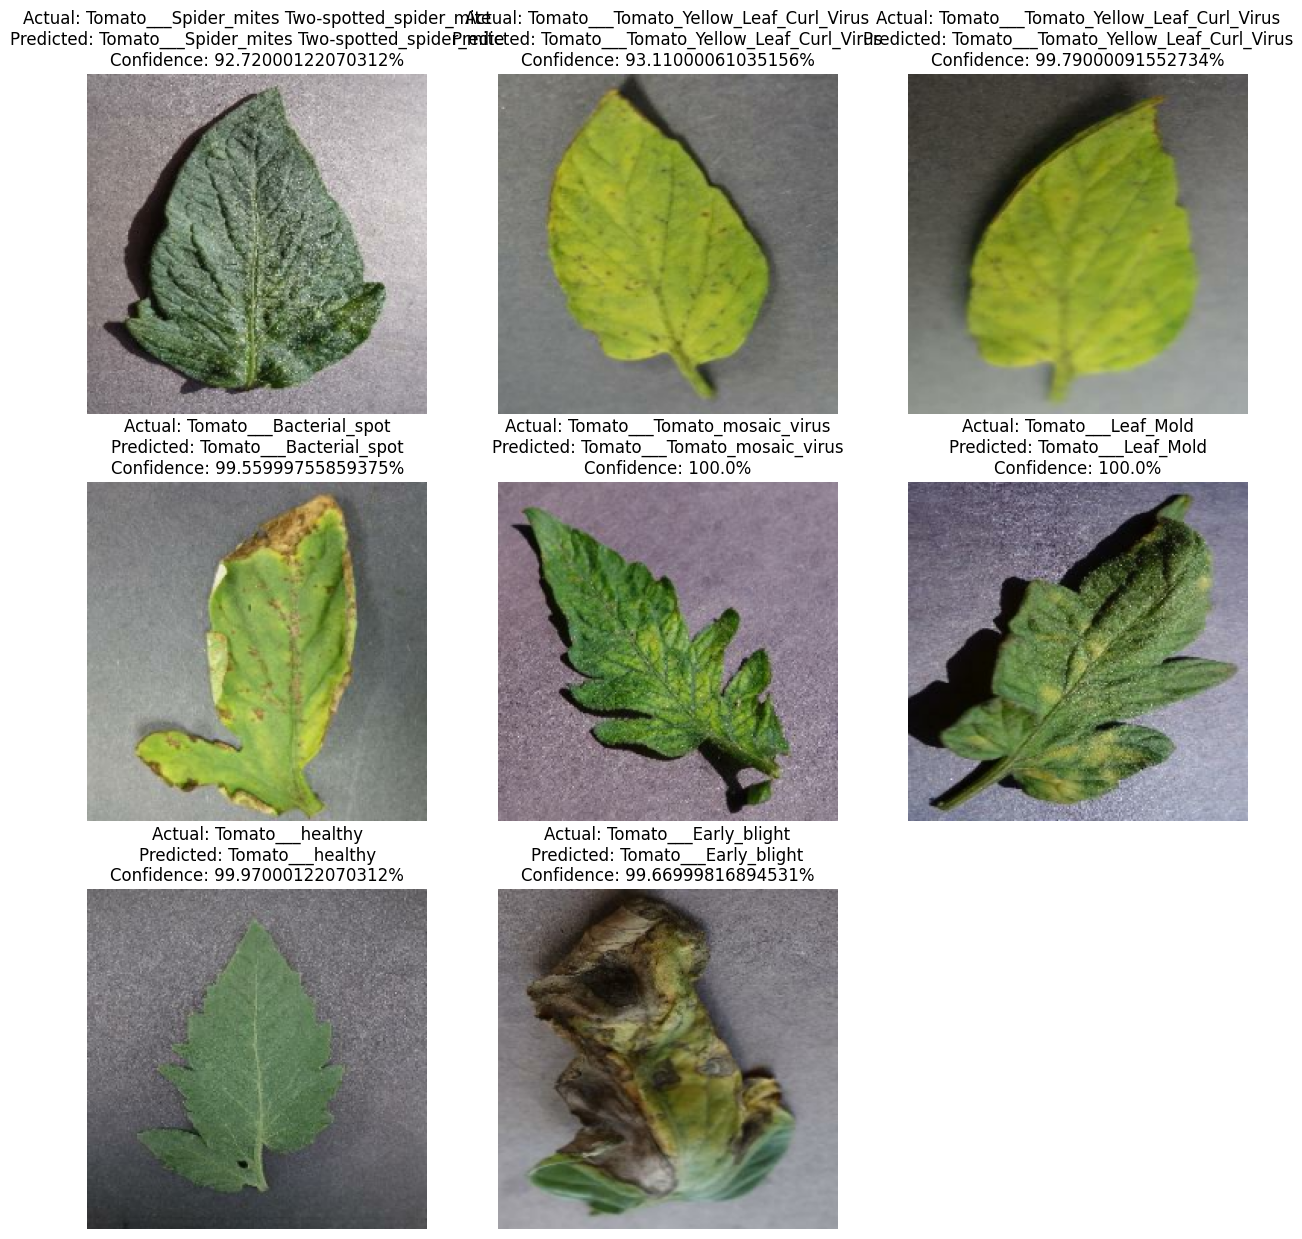

In [30]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

**Model Predictions**

In [31]:
y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    preds_list = model.predict(images)
    preds = preds_list[0]  # main_output predictions: shape (batch_size, num_classes)

    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()

    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)  # add the raw probabilities

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

**Accuracy**

In [33]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 99.09%


**Precision**

In [34]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'
print(f"Precision: {precision * 100:.2f}%")

Precision: 99.11%


**Recall**

In [35]:
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall * 100:.2f}%")

Recall: 99.09%


**F1 Score**

In [36]:
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"f1: {f1 * 100:.2f}%")

f1: 99.10%


**Confusion Matrix**

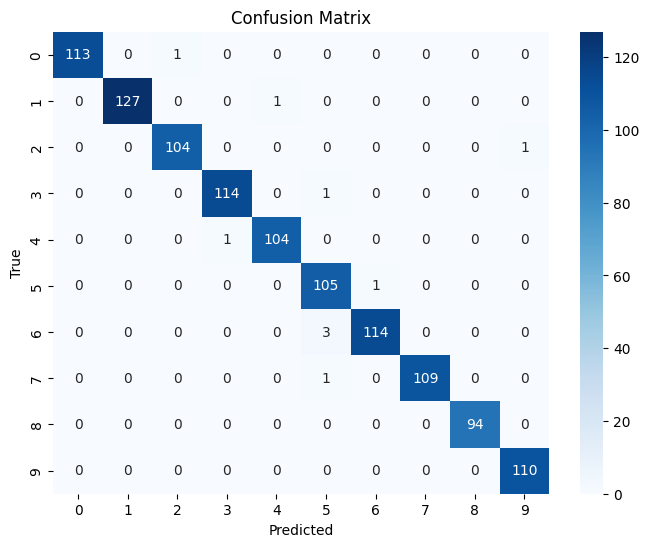

In [37]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**AUROC**

In [38]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)

Macro-Averaged ROC-AUC Score: 99.98%


In [39]:
model.save('tomato-leaf-disease_GoogleNet_model.keras')

print("Model saved successfully!")

Model saved successfully!
